# A notebook with the FRB/US model
This notebook is based on the the FRB/US model packages located here (https://www.federalreserve.gov/econres/us-models-package.htm). The packages provides an Eviews (https://www.eviews.com/) implementation. The Eviews modelspecification has been transformed to ModelFlow BusinessLogic specification. 

FRB/US comes in two flawors: **VAR** in which expectaions are generated by backward looking equations, and **MCE** in which expectation are based on leaded values.

This notebook implement the **MCE** flavour. The presence of leaded variable implies that the model has to be solved for all quarters in one go. The **VAR** model which has only lagged variables can be solved for each quarter in turn. 

The tool used is highly experimental and the results are purely for illustration. 

You can run each cell by pressing the run tool or shift+enter
To run all cells use select cell/run all in the menu bar. 

# Import Python libraries

In [1]:
%matplotlib inline

import pandas as pd
from numba import jit
import numpy as np
 
from modelclass import model  
import modelmf
from modeljupyter import inputwidget
from modelhelp import ttimer

# Prepare some stuff

In [2]:
turbo = 0   # Determines if the the model is compiled or not 

# define af function which is in Eviews but not in Python
@jit("f8(b1,f8,f8)")
def recode(condition,yes,no):
    '''Function which recratetes the functionality of @recode from eviews ''' 
    return yes if condition else no

basedf = pd.read_pickle('frbus/data/longmcebase.pc').pipe(
lambda df: df[[c for c in df.columns if not c.startswith('DA')]].astype(np.float64))

ffrbusmce  = open('frbus/model/ffrbusmce.txt','rt').read()

# Create a model class instance

In [6]:
mfrbusmce = model(ffrbusmce,modelname='FrbUS_MCE')

# Run the baseline 

In [7]:
with ttimer('baseline newton all periods '):
    baseres = mfrbusmce.newtonstack(basedf,'2020q1','2040q4',antal=70,silent=False,nchunk=50,reset=1,
                                  ljit=turbo,nljit=turbo,timeit=0,nonlin=10,newtonalfa = 1 , newtonnodamp=4)

baseline newton all periods  started at :        18:28:59 
Will start calculating: FrbUS_MCE
Prepare model for calculate derivatives for Newton solver
Model                           : FrbUS_MCE
Number of endogeneus variables  : 285
Number of derivatives           : 1074
Will start calculating:  all lags and leads
Create res function for  all lags and leads
 all lags and leads solved  
Creating new derivatives and new solver
Iteration  0 Sum of distances    4,976.752799
Iteration  1 Sum of distances   98,138.042143
Iteration  2 Sum of distances    9,151.226964
Iteration  3 Sum of distances    5,800.425676
Iteration  4 Sum of distances    1,715.755281
Iteration  5 Sum of distances      529.913528
Iteration  6 Sum of distances      288.075728
Iteration  7 Sum of distances       35.724075
Iteration  8 Sum of distances       41.082425
Iteration  9 Sum of distances        3.800566
Iteration  10 Sum of distances        5.062091
Updating solver, iteration 10
Will start calculating:  all lags 

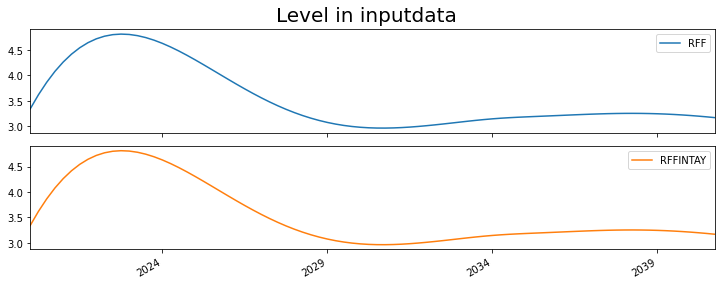

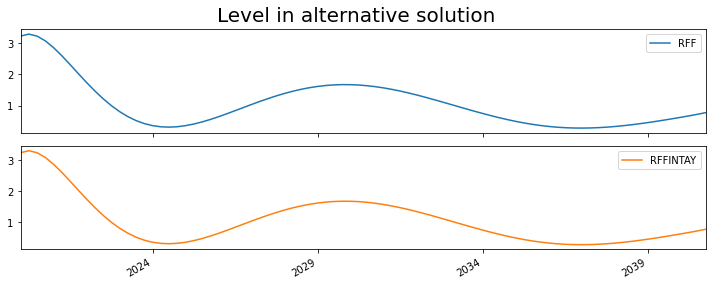

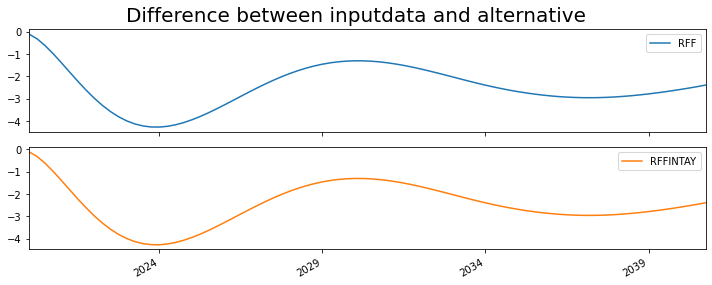

In [8]:
mfrbusmce.basedf = basedf
mfrbusmce.lastdf = baseres 
_ = mfrbusmce['rff RFFINTAY'].base.plot(colrow=1,title='Level in inputdata')
_ = mfrbusmce['rff RFFINTAY'].plot(colrow=1,title='Level in alternative solution')
_ = mfrbusmce['rff RFFINTAY'].dif.plot(colrow=1,title='Difference between inputdata and alternative')


# Create an alternative scenario and run it 

In [8]:
altdf = baseres.copy()
altdf=altdf.mfcalc('''
rffintay_aerr = rffintay_aerr = 0.01
dmpex    = 0 
dmprr    = 0
dmptay   = 0
dmptlr   = 0 
dmpintay = 1

dmpalt   = 0
dmpgen   = 0
''',silent=1)
    
    
with ttimer('newton all periods '):
    altres = mfrbusmce.newtonstack(altdf,stats=0,antal=70,silent=False,reset=0,
                                  ljit=turbo,timeit=0,nonlin=20,newtonalfa = 1, newtonnodamp=10,nljit=turbo,)

newton all periods  started at :        10:40:43 
Will start calculating: testmodel
Iteration  0 Sum of distances        0.840001
Updating solver, iteration 0
Iteration  1 Sum of distances      783.581189
Iteration  2 Sum of distances        9.749266
Iteration  3 Sum of distances        1.097418
Iteration  4 Sum of distances        0.019759
Iteration  5 Sum of distances        0.002153
Iteration  6 Sum of distances        0.000047
Solved in 6 iterations
testmodel solved  
newton all periods  took       :           6.781 Seconds


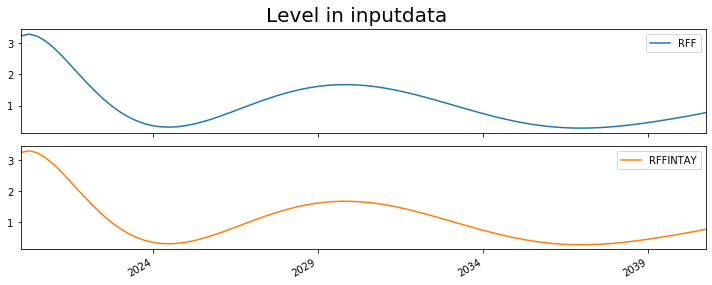

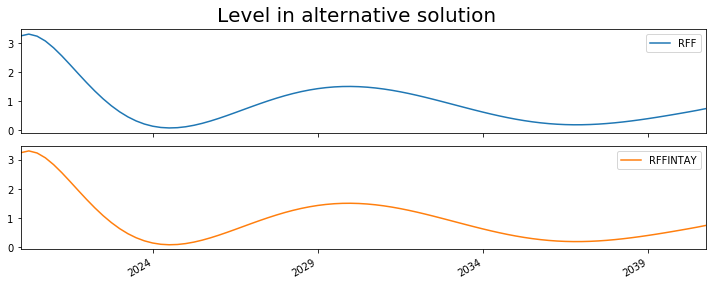

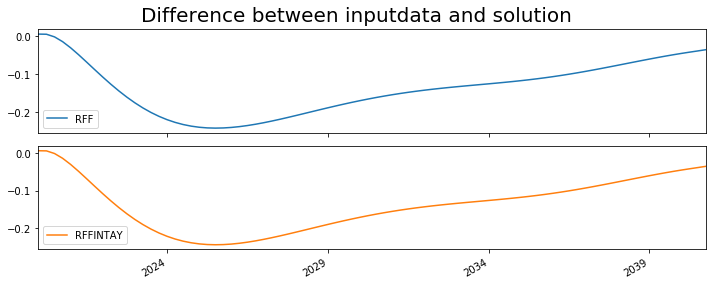

In [9]:
mfrbusmce.basedf= baseres 
mfrbusmce.lastdf= altres 
_ = mfrbusmce['rff RFFINTAY'].base.plot(colrow=1,title='Level in inputdata')
_ = mfrbusmce['rff RFFINTAY'].plot(colrow=1,title='Level in alternative solution')
_ = mfrbusmce['rff RFFINTAY'].dif.plot(colrow=1,title='Difference between inputdata and solution')
